# notebook for create init and true test model

In [2]:
import numpy as np
import math

# grid
R_earth = 6371.0 #6378.1370

rr1=6070
rr2=6400
tt1=(30.0-1.5)/180*math.pi
tt2=(50.0+1.5)/180*math.pi
pp1=(15.0-1.5)/180*math.pi
pp2=(40.0+1.5)/180*math.pi

n_rtp = [55,55,55]
dr = (rr2-rr1)/(n_rtp[0]-1)
dt = (tt2-tt1)/(n_rtp[1]-1)
dp = (pp2-pp1)/(n_rtp[2]-1)
rr = np.array([rr1 + x*dr for x in range(n_rtp[0])])
tt = np.array([tt1 + x*dt for x in range(n_rtp[1])])
pp = np.array([pp1 + x*dp for x in range(n_rtp[2])])

# initial model
gamma = 0.0
#s0 = 1.0/6.0
slow_p=0.04
ani_p=0.03

eta_init = np.zeros(n_rtp)
xi_init  = np.zeros(n_rtp)
zeta_init = np.zeros(n_rtp)
fun_init = np.zeros(n_rtp)
vel_init = np.zeros(n_rtp)

# true model
eta_true = np.zeros(n_rtp)
xi_true  = np.zeros(n_rtp)
zeta_true = np.zeros(n_rtp)
fun_true = np.zeros(n_rtp)
vel_true = np.zeros(n_rtp)

c=0
for ir in range(n_rtp[2]):
    for it in range(n_rtp[1]):
        for ip in range(n_rtp[0]):
            #eta_init[ir,it,ip] = 0.0
            #xi_init[ir,it,ip]  = 0.0
            zeta_init[ir,it,ip] = gamma*math.sqrt(eta_init[ir,it,ip]**2 + xi_init[ir,it,ip]**2)
            
            if (rr[ir]>6351):
                fun_init[ir,it,ip] = 1.0/(5.8+(6371-rr[ir])/20.0*0.7)
            elif (rr[ir]>6336):
                fun_init[ir,it,ip] = 1.0/(6.5+(6351-rr[ir])/15.0*0.6)
            elif (rr[ir]>5961):
                fun_init[ir,it,ip] = 1.0/(8.0+(6336-rr[ir])/375.0*1) 
            else:
                fun_init[ir,it,ip] = 1.0/9.0

            vel_init[ir,it,ip] = 1.0/fun_init[ir,it,ip]

            # true model
            if (tt[it] >= 30.0/180.0*math.pi and tt[it] <= 50.0/180.0*math.pi \
            and pp[ip] >= 15.0/180.0*math.pi and pp[ip] <= 40.0/180.0*math.pi \
            and rr[ir] >= 6211.0             and rr[ir] <= 6371.0):
                c+=1
                sigma = math.sin(4.0*math.pi*(tt[it]-30.0/180.0*math.pi)/(20.0/180.0*math.pi)) \
                       *math.sin(4.0*math.pi*(pp[ip]-15.0/180.0*math.pi)/(25.0/180.0*math.pi)) \
                       *math.sin(2.0*math.pi*(rr[ir]-6211.0)/160.0)
            else:
                sigma = 0.0

            if sigma < 0:
                psi = 60.0/180.0*math.pi
            elif sigma > 0:
                psi = 150.0/180.0*math.pi
            else:
                psi = 0.0

            eta_true[ir,it,ip] = ani_p*abs(sigma)*math.sin(2.0*psi)
            xi_true[ir,it,ip]  = ani_p*abs(sigma)*math.cos(2.0*psi)
            zeta_true[ir,it,ip] = gamma*math.sqrt(eta_true[ir,it,ip]**2 + xi_true[ir,it,ip]**2)
            fun_true[ir,it,ip] = fun_init[ir,it,ip]/(1.0+sigma*slow_p)
            vel_true[ir,it,ip] = 1.0/fun_true[ir,it,ip]    


r_earth = R_earth #6378.1370
print("depminmax {} {}".format(r_earth-rr1,r_earth-rr2))
print(c)


depminmax 301.0 -29.0
59878


In [3]:
# write out
import h5py

fout_init = h5py.File('test_model_init.h5', 'w')
fout_true = h5py.File('test_model_true.h5', 'w')

# write out the arrays eta_init, xi_init, zeta_init, fun_init, a_init, b_init, c_init, f_init
fout_init.create_dataset('eta',  data=eta_init)
fout_init.create_dataset('xi',    data=xi_init)
fout_init.create_dataset('zeta',data=zeta_init)
fout_init.create_dataset('vel',  data=vel_init)

# writeout the arrays eta_true, xi_true, zeta_true, fun_true, a_true, b_true, c_true, f_true
fout_true.create_dataset('eta',  data=eta_true)
fout_true.create_dataset('xi',    data=xi_true)
fout_true.create_dataset('zeta',data=zeta_true)
fout_true.create_dataset('vel',  data=vel_true)

fout_init.close()
fout_true.close()


# prepare src station file

```
        26 1992  1  1  2 43  56.900    1.8000     98.9000 137.00  2.80    8    305644 <- src   　: id_src year month day hour min sec lat lon dep_km mag num_recs id_event
     26      1      PCBI       1.8900     98.9253   1000.0000  P   10.40  18.000      <- arrival : id_src id_rec name_rec lat lon elevation_m phase epicentral_distance_km arrival_time_sec
     26      2      MRPI       1.6125     99.3172   1100.0000  P   50.84  19.400
     26      3      HUTI       2.3153     98.9711   1600.0000  P   57.84  19.200

```

In [10]:
import random
random.seed(123456789)

# dummys
year_dummy = 1998
month_dummy = 1
day_dummy = 1
hour_dummy = 0
minute_dummy = 0
second_dummy = 0
mag_dummy = 3.0
id_dummy = 1000
st_name_dummy = 'AAAA'
phase_dummy = 'P'
arriv_t_dummy = 0.0

mergin_rate = 5.0/100.0


tt1deg = tt1 * 180.0/math.pi + (tt2-tt1)*180.0/math.pi*mergin_rate
tt2deg = tt2 * 180.0/math.pi - (tt2-tt1)*180.0/math.pi*mergin_rate
pp1deg = pp1 * 180.0/math.pi + (pp2-pp1)*180.0/math.pi*mergin_rate
pp2deg = pp2 * 180.0/math.pi - (pp2-pp1)*180.0/math.pi*mergin_rate


n_src = 100
n_rec = [4 for x in range(n_src)]


lines = []

pos_src=[]
pos_rec=[]

nij_src = math.sqrt(n_src)
nij_rec = math.sqrt(n_rec[0])

# create receiver coordinates
elev_recs=[]
lon_recs=[]
lat_recs=[]
rec_names=[]
for i in range(n_rec[0]):
    rec_names.append("sta_"+str(i))
    # regularly
    elev_recs.append(0.0)
    tmp_ilon = i%nij_rec
    tmp_ilat = int(i/nij_rec)
    lon_recs.append(pp1deg + tmp_ilon*(pp2deg-pp1deg)/nij_rec)
    lat_recs.append(tt1deg + tmp_ilat*(tt2deg-tt1deg)/nij_rec)



# create dummy src
for i_src in range(n_src):
    # define one point in the domain (rr1 bottom, rr2 top)
    dep = (R_earth-rr1)*0.9
    tmp_ilon = int(i_src%nij_src)
    tmp_ilat = int(i_src/nij_src)
    lon = pp1deg + tmp_ilon*(pp2deg-pp1deg)/nij_src
    lat = tt1deg + tmp_ilat*(tt2deg-tt1deg)/nij_src


    src = [i_src, year_dummy, month_dummy, day_dummy, hour_dummy, minute_dummy, second_dummy, lat, lon, dep, mag_dummy, n_rec[i_src], id_dummy]
    lines.append(src)

    pos_src.append([lon,lat,dep])

    # create dummy station
    for i_rec in range(n_rec[i_src]):
        #elev_rec = random.uniform(0.0,-10.0) # elevation in m
        #lon_rec  = random.uniform(pp1deg,pp2deg)
        #lat_rec  = random.uniform(tt1deg,tt2deg)

        rec = [i_src, i_rec, st_name_dummy+"_"+str(i_rec), lat_recs[i_rec], lon_recs[i_rec], elev_recs[i_rec], phase_dummy, arriv_t_dummy]
        lines.append(rec)

        pos_rec.append([lon_recs[i_rec],lat_recs[i_rec],elev_recs[i_rec]])

# write out ev_arrivals file
fname = 'src_rec_test.dat'

with open(fname, 'w') as f:
    for line in lines:
        for elem in line:
            f.write('{} '.format(elem))
        f.write('\n')
        

In [14]:
tt2deg

50.35

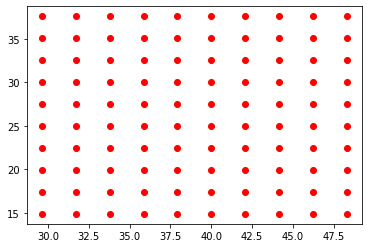

In [11]:
# draw src and rec positions
import matplotlib.pyplot as plt

for i_src in range(n_src):
    plt.scatter(pos_src[i_src][1],pos_src[i_src][0],c='r',marker='o')

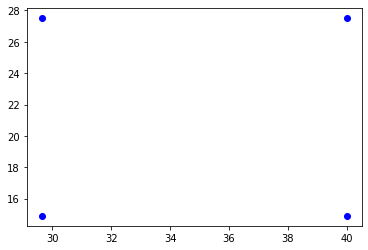

In [12]:
# plot receivers
for i_rec in range(n_rec[0]):
    plt.scatter(pos_rec[i_rec][1],pos_rec[i_rec][0],c='b',marker='o')